# Using GPU

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms
import numpy
import matplotlib.pyplot as plt

In [3]:
cifar10_train_dataset = torchvision.datasets.CIFAR10("../data/cifar10", train=True, download=True, 
                                                     transform=torchvision.transforms.ToTensor() )
cifar10_test_dataset = torchvision.datasets.CIFAR10("../data/cifar10", train=False, download=True, 
                                                    transform=torchvision.transforms.ToTensor() )

16.9%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100.0%

Extracting ../data/cifar10/cifar-10-python.tar.gz to ../data/cifar10
Files already downloaded and verified


In [4]:
type(cifar10_train_dataset).mro()

[torchvision.datasets.cifar.CIFAR10,
 torchvision.datasets.vision.VisionDataset,
 torch.utils.data.dataset.Dataset,
 object]

In [5]:
im, l = cifar10_train_dataset[0]

In [6]:
im.dtype

torch.float32

In [7]:
cifar10_train_dataset.data[0].shape

(32, 32, 3)

In [8]:
cifar10_train_dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

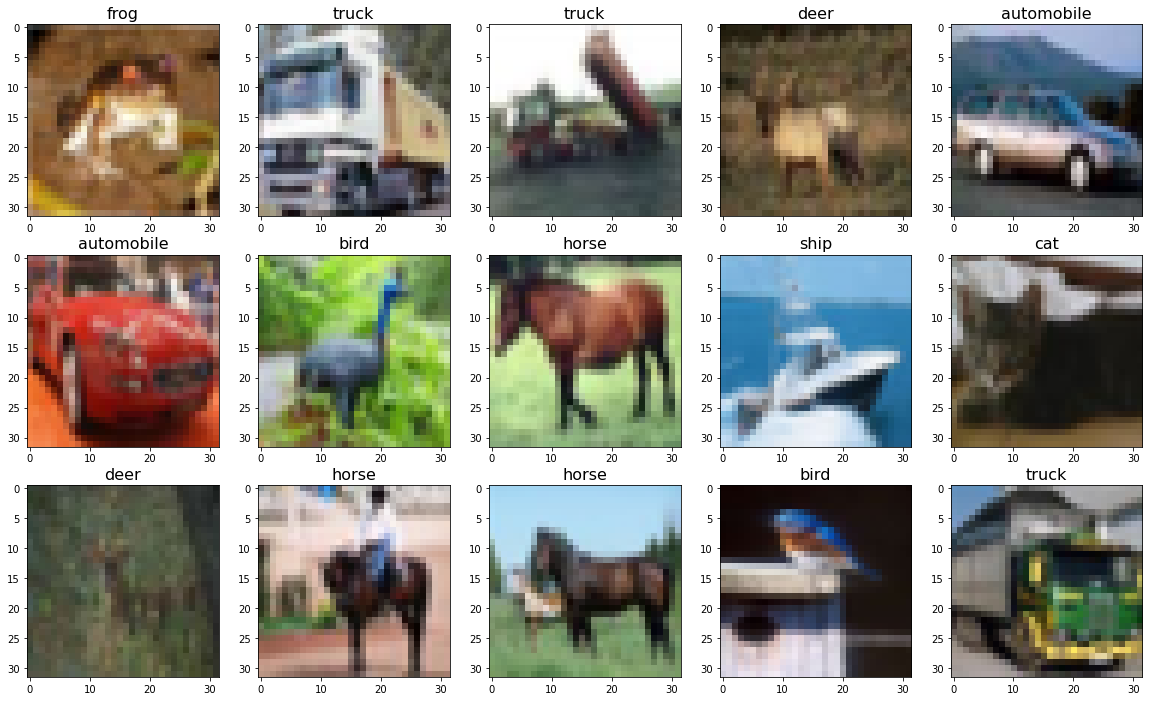

In [9]:
rows=3
cols=5
size=4
classes = cifar10_train_dataset.classes
fig, axes = plt.subplots(rows,cols, figsize=(cols*size,rows*size))
for i in range(cols*rows):
    ax = axes.ravel()[i]
    im, lbl = cifar10_train_dataset[i]
    ax.imshow(im.numpy().transpose(1,2,0))
    ax.set_title(classes[lbl], fontsize=16)


In [ ]:
torch.cuda.is_available()

In [ ]:
for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_name(i), torch.cuda.get_device_capability(i))
    prop = torch.cuda.get_device_properties(i)
    print(f"{prop.total_memory/2**30:4.1f}GB", prop.multi_processor_count, prop.is_integrated)
    

In [ ]:
if torch.cuda.is_available():
    dev = torch.device(torch.cuda.device_count()-1)
else:
    dev = 'cpu'

In [ ]:
cifar10_train_loader  = torch.utils.data.DataLoader(cifar10_train_dataset, batch_size=512)
cifar10_test_loader = torch.utils.data.DataLoader(cifar10_test_dataset, batch_size=512)

In [ ]:
input_size = 3*32*32
print(input_size)

In [ ]:
model = torch.nn.Sequential(
    nn.Linear(input_size,1200), nn.ReLU(),
    nn.Linear(1200,600), nn.ReLU(),
    nn.Linear(600,300), nn.ReLU(),
    nn.Linear(300,10)
)

In [ ]:
model.to(dev)

In [ ]:
ce_loss = torch.nn.CrossEntropyLoss()

In [ ]:
optim = torch.optim.SGD(model.parameters(), lr=0.1)

In [ ]:
%%time
for e in range(5):
    for features, labels in cifar10_train_loader:  
        features = features.view(-1,input_size).to(dev)
        labels = labels.to(dev)
        optim.zero_grad()
        pred = model(features)
        loss = ce_loss(pred,labels)
        loss.backward()
        optim.step()   
    print(e, loss.item())        

In [ ]:
def data_loader_accuracy(model, loader, dev):
    with torch.no_grad():
        good_count = 0
        count = 0
        for features, labels in loader:  
            features = features.view(-1,input_size).to(dev)
            labels = labels.to(dev)
            pred = model(features)
            classes = torch.argmax(pred,1)
            good_count += torch.sum(classes==labels).item()
            count+=len(labels)
        return good_count/count    

In [ ]:
data_loader_accuracy(model,cifar10_train_loader, dev)

In [ ]:
data_loader_accuracy(model,cifar10_test_loader, dev)

## All on GPU

In [ ]:
cf10_train_data   = cifar10_train_dataset.data
cf10_train_labels = cifar10_train_dataset.targets

In [ ]:
cf10_test_data   = cifar10_test_dataset.data
cf10_test_labels = cifar10_test_dataset.targets

In [ ]:
type(cf10_train_data)

In [ ]:
type(cf10_train_labels)

In [ ]:
cf10_train_data_t = torch.from_numpy(cf10_train_data.reshape(-1,input_size)/256.0).to(
    dtype=torch.float32, device = dev)
cf10_train_labels_t = torch.tensor(cf10_train_labels,dtype=torch.long, device=dev)

In [ ]:
cf10_train_dataset = torch.utils.data.TensorDataset(cf10_train_data_t, cf10_train_labels_t)

In [ ]:
cf10_train_loader = torch.utils.data.DataLoader(cf10_train_dataset, batch_size=512)

In [ ]:
cf10_test_data_t = torch.from_numpy(cf10_test_data.reshape(-1,input_size)/256.0).to(
    dtype=torch.float32, device = dev)
cf10_test_labels_t = torch.tensor(cf10_test_labels,dtype=torch.long, device=dev)

In [ ]:
cf10_test_dataset = torch.utils.data.TensorDataset(cf10_test_data_t, cf10_test_labels_t)

In [ ]:
cf10_test_loader = torch.utils.data.DataLoader(cf10_test_dataset, batch_size=1024)

In [ ]:
model = torch.nn.Sequential(
    nn.Linear(input_size,1200), nn.ReLU(),
    nn.Linear(1200,600), nn.ReLU(),
    nn.Linear(600,300), nn.ReLU(),
    nn.Linear(300,10)
)

In [ ]:
model.to(dev)

In [ ]:
ce_loss = torch.nn.CrossEntropyLoss()

In [ ]:
optim = torch.optim.SGD(model.parameters(), lr=0.1)

In [ ]:
%%time
for e in range(5):
    for features, labels in cf10_train_loader:  
        optim.zero_grad()
        pred = model(features)
        loss = ce_loss(pred,labels)
        loss.backward()
        optim.step()   
    print(e, loss.item())        

In [ ]:
def data_loader_accuracy2(model, loader, dev):
    with torch.no_grad():
        good_count = 0
        count = 0
        for features, labels in loader:  
            pred = model(features)
            classes = torch.argmax(pred,1)
            good_count += torch.sum(classes==labels).item()
            count+=len(labels)
        return good_count/count    

In [ ]:
data_loader_accuracy2(model,cf10_train_loader, dev)

## Automatic Mixed Precision (TPU)

In [ ]:
from torch.cuda.amp import autocast

In [ ]:
model = torch.nn.Sequential(
    nn.Linear(input_size,4096), nn.ReLU(),
    nn.Linear(4096,4096), nn.ReLU(),
    nn.Linear(4096,2048), nn.ReLU(),
    nn.Linear(2048,1024), nn.ReLU(),
    nn.Linear(1024,512), nn.ReLU(),
    nn.Linear(512,256), nn.ReLU(),
    nn.Linear(256,10)
)

In [ ]:
model.to(dev)

In [ ]:
ce_loss = torch.nn.CrossEntropyLoss()

In [ ]:
optim = torch.optim.SGD(model.parameters(), lr=0.01, momentum=.9)

In [ ]:
%%time
use_amp = True
for e in range(120):
    for features, labels in cf10_train_loader:  
        optim.zero_grad()
        with autocast(enabled=use_amp):
            pred = model(features)
            loss = ce_loss(pred,labels)
        loss.backward()
        optim.step()   
    #print(e, loss)        

In [ ]:
data_loader_accuracy2(model,cf10_train_loader, dev)

In [ ]:
data_loader_accuracy2(model,cf10_test_loader, dev)

-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:02:00.0  On |                  N/A |
|  0%   49C    P8     4W / 250W |   2414MiB / 11011MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  On   | 00000000:03:00.0 Off |                  N/A |
| 72%   72C    P2   231W / 250W |   7284MiB / 11019MiB |     88%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
